In [1]:
# Import general purpose packages
import numpy as np 
import pandas as pd 
import sys
import json
import os
import re

# This is what we are using for data preparation and ML part (thanks, Rafal, for great tutorial)
from sklearn.preprocessing import LabelBinarizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential

from keras.layers import Activation, Dense,Dropout



In [2]:
artists = pd.read_csv('artists-data.csv')
songs = pd.read_csv('lyrics-data.csv') #load the list of songs

In [3]:
artists.head()

,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
3,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
4,A Cruz Está Vazia,13,0.0,/a-cruz-esta-vazia/,Rock,Rock


In [4]:
songs.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


In [5]:
songs['Idiom'].value_counts()

ENGLISH           114723
PORTUGUESE         85085
SPANISH             4812
ITALIAN              626
FRENCH               471
GERMAN               314
KINYARWANDA           88
ICELANDIC             47
SWEDISH               27
FINNISH               24
INDONESIAN            17
ESTONIAN              12
GALICIAN              12
IRISH                  9
HAITIAN_CREOLE         9
DANISH                 9
BASQUE                 8
TAGALOG                7
NORWEGIAN              7
CROATIAN               7
CATALAN                6
SUNDANESE              6
DUTCH                  5
SWAHILI                5
MALAY                  4
RUSSIAN                4
SERBIAN                3
NYANJA                 2
ARABIC                 2
TURKISH                2
MALAGASY               2
JAPANESE               2
SESOTHO                2
CEBUANO                2
KURDISH                2
HMONG                  1
SLOVAK                 1
KOREAN                 1
SLOVENIAN              1
AFRIKAANS              1


In [6]:
data = pd.DataFrame() 
G=artists.Genre.unique()
for genre in G:
    Genre_artists = artists[artists['Genre']==genre] # filter artists by genre
    Genre_songs = pd.merge(songs, Genre_artists, how='inner', left_on='ALink', right_on='Link') #inner join of pop artists with songs to get only songs by pop artists
    Genre_songs = Genre_songs[['Genre', 'Artist', 'SName', 'Lyric','Idiom']].rename(columns={'SName':'Song'})#leave only columns of interest and rename some of them.
    Genre_songs = Genre_songs.dropna() # Remove incomplete records, cleanse lyrics
    #Genre_songs = Genre_songs[songs['Lyric']!='Instrumental'].head(SONGS_PER_GENRE).applymap(cleanse) #Remove instrumental compositions  and limit the size of final dataset
    data=pd.concat([data, Genre_songs])
    
    
data=data.loc[data['Idiom'] == 'ENGLISH']

data.index = range(len(data))


In [7]:
data['Genre'].value_counts()

Rock            60585
Pop             40294
Hip Hop         23108
Funk Carioca      104
Sertanejo          87
Samba              52
Name: Genre, dtype: int64

In [8]:
#Keep only 3 most frequent genrres
data=data.loc[data['Genre'].isin(['Rock','Pop','Hip Hop'])]
data.index = range(len(data))


In [9]:
#Convert Categorical genre to binary label
GenreBinarizer = LabelBinarizer().fit(data['Genre'])
Genre_Label = GenreBinarizer.transform(data['Genre'])


Genre_Label_df = pd.DataFrame(Genre_Label, columns =['G_H', 'G_P', 'G_R'])

final_data=pd.concat([data, Genre_Label_df], axis=1)

##### Shuffle data
final_data=final_data.sample(frac=1) 
final_data.index = range(len(final_data))
final_data=final_data.drop(columns=['Genre', 'Artist','Idiom'])

In [10]:
#Creat train,validation and test data
train_data=final_data[:87000]
validation_data=final_data[87000:111600]
test_data=final_data[111600:]

In [11]:
documents = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(train_data)):
    temp=str(train_data['Lyric'].values[sen])
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(temp))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    

    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
    
    
train_Lyric=documents

In [12]:
documents = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(validation_data)):
    temp=str(validation_data['Lyric'].values[sen])
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(temp))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    

    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
    
    
validation_Lyric=documents

In [13]:
documents = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(test_data)):
    temp=str(test_data['Lyric'].values[sen])
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(temp))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    

    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
    
    
test_Lyric=documents

In [14]:
tfidfconverter = TfidfVectorizer(max_features=2000,min_df=1, max_df=0.9, stop_words=stopwords.words('english'))
#
X_Lyric_train = tfidfconverter.fit_transform(train_Lyric).toarray()

X_Lyric_validation = tfidfconverter.transform(validation_Lyric).toarray()

X_Lyric_test = tfidfconverter.transform(test_Lyric).toarray()



In [15]:
y_train=train_data[['G_H','G_P','G_R']].to_numpy()
y_validation=validation_data[['G_H','G_P','G_R']].to_numpy()
y_test=test_data[['G_H','G_P','G_R']].to_numpy()





In [26]:
X_train_dim=X_Lyric_train.shape[1]
model = Sequential()
model.add(Dense(8, input_dim=X_train_dim, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history=model.fit(x=X_Lyric_train, y=y_train, validation_data=(X_Lyric_validation,y_validation),epochs=10, batch_size=20)

Epoch 1/10
4350/4350 [==============================] - 9s 2ms/step - loss: 0.6218 - accuracy: 0.7130 - val_loss: 0.7161 - val_accuracy: 0.6643
Epoch 2/10
4350/4350 [==============================] - 10s 2ms/step - loss: 0.6158 - accuracy: 0.7153 - val_loss: 0.7192 - val_accuracy: 0.6639
Epoch 3/10
4350/4350 [==============================] - 9s 2ms/step - loss: 0.6111 - accuracy: 0.7190 - val_loss: 0.7216 - val_accuracy: 0.6652
Epoch 4/10
4350/4350 [==============================] - 9s 2ms/step - loss: 0.6067 - accuracy: 0.7197 - val_loss: 0.7251 - val_accuracy: 0.6618
Epoch 5/10
4350/4350 [==============================] - 9s 2ms/step - loss: 0.6027 - accuracy: 0.7219 - val_loss: 0.7266 - val_accuracy: 0.6623
Epoch 6/10
4350/4350 [==============================] - 9s 2ms/step - loss: 0.5987 - accuracy: 0.7237 - val_loss: 0.7289 - val_accuracy: 0.6606
Epoch 7/10
4350/4350 [==============================] - 9s 2ms/step - loss: 0.5953 - accuracy: 0.7259 - val_loss: 0.7345 - val_accuracy

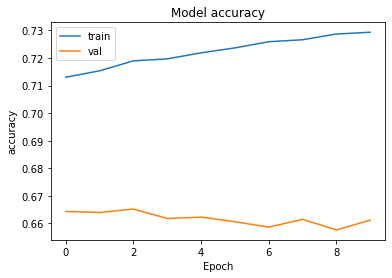

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()